In [12]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import GaussianNoise, UpSampling2D, Conv2DTranspose, Conv2D, Dense, Lambda, Input, Flatten, Reshape, BatchNormalization, ReLU, LeakyReLU, MaxPooling2D
from tensorflow.keras.models import Model, load_model
import tensorflow.keras.layers as layers
import tensorflow.keras.backend as K
from tensorflow.keras.losses import mse, binary_crossentropy
from tensorflow.keras.datasets import mnist
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt



import os
import glob

In [2]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [54]:
import numpy as np
def sampling(args):
    """Reparameterization trick by sampling from an isotropic unit Gaussian.

    # Arguments
        args (tensor): mean and log of variance of Q(z|X)

    # Returns
        z (tensor): sampled latent vector
    """
    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    # by default, random_normal has mean = 0 and std = 1.0
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon


In [55]:
# network parameters
width = 64
height = 64
latent_dim = 100


# VAE model = encoder + decoder
# build encoder model
inputs = Input(shape=(width,height,3), name='encoder_input')
#x = GaussianNoise(0.5)(inputs) #Noise layer for denoising VAE
x = Conv2D(16, 3, strides=2, padding='same')(inputs)
x = BatchNormalization()(x)
x = LeakyReLU(0.1)(x)
x = Conv2D(32, 3, strides=2, padding='same')(x)
x = BatchNormalization()(x)
x = LeakyReLU(0.1)(x)
x = Conv2D(64, 3, strides=2, padding='same')(x)
x = BatchNormalization()(x)
x = LeakyReLU(0.1)(x)
x = Conv2D(64, 3, strides=2, padding='same')(x)
x = BatchNormalization()(x)
x = LeakyReLU(0.1)(x)

(_,h,w,c) = x.shape

x = Flatten()(x)

z_mean = Dense(latent_dim, name='z_mean')(x)
z_log_var = Dense(latent_dim, name='z_log_var')(x)

# use reparameterization trick to push the sampling out as input
# note that "output_shape" isn't necessary with the TensorFlow backend
z = Lambda(sampling, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])

# instantiate encoder model
encoder = Model(inputs, [z_mean, z_log_var, z], name='encoder')
encoder.summary()


# # build decoder model
latent_inputs = Input(shape=(latent_dim,), name='z_sampling')
x = Dense(h*w*c, activation='relu')(latent_inputs)
x = Reshape((h,w,c))(x)
x = Conv2D(64,3, strides=1, padding='same')(x)
x = BatchNormalization()(x)
x = LeakyReLU(0.1)(x)
x = UpSampling2D()(x)
x = Conv2D(64,3, strides=1, padding='same')(x)
x = BatchNormalization()(x)
x = LeakyReLU(0.1)(x)
x = UpSampling2D()(x)
x = Conv2D(32,3, strides=1, padding='same')(x)
x = BatchNormalization()(x)
x = LeakyReLU(0.1)(x)
x = UpSampling2D()(x)
x = Conv2D(16,3, strides=1, padding='same')(x)
x = BatchNormalization()(x)
x = LeakyReLU(0.1)(x)
x = UpSampling2D()(x)

outputs = Conv2D(3,3, strides=1, activation='sigmoid', padding='same')(x)


# # instantiate decoder model
decoder = Model(latent_inputs, outputs, name='decoder')
decoder.summary()

# # instantiate VAE model
outputs = decoder(encoder(inputs)[2])
vae = Model(inputs, outputs, name='cnn_vae')
vae.summary()
history = []

Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      [(None, 64, 64, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_31 (Conv2D)              (None, 32, 32, 16)   448         encoder_input[0][0]              
__________________________________________________________________________________________________
batch_normalization_28 (BatchNo (None, 32, 32, 16)   64          conv2d_31[0][0]                  
__________________________________________________________________________________________________
leaky_re_lu_28 (LeakyReLU)      (None, 32, 32, 16)   0           batch_normalization_28[0][0]     
____________________________________________________________________________________________

In [11]:
#Beta VAE warmup
from tensorflow.keras.callbacks import Callback
class Warmup(Callback):
    def __init__(self, beta, warmup_epoch):
        self.warmup_epoch = warmup_epoch
        self.beta = beta

    def on_epoch_end(self, epoch, logs={}):
        value = (epoch/self.warmup_epoch) * (epoch <= self.warmup_epoch) + 1.0 * (epoch > self.warmup_epoch)
        K.set_value(self.beta, value)
        print(f' epoch {epoch}, beta = {K.get_value(self.beta)}')

def vae_loss(y_true, y_pred):
    reconstruction_loss = mse(K.flatten(y_true), K.flatten(y_pred))
    reconstruction_loss *= width*height # common practice to scale with w*h
    kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
    kl_loss = K.sum(kl_loss, axis=-1)
    kl_loss *= -0.5
    kl_loss * beta
    return K.mean(reconstruction_loss + kl_loss)
    


beta = K.variable(0.0)
optimizer = Adam(0.0005)

vae.compile(optimizer='adam', loss=vae_loss, experimental_run_tf_function=False)

In [2]:
training_data_generator = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.8,
    horizontal_flip=False)

# validation_generator = training_data_generator.flow_from_directory(
#    './Birds-200-2011/',
#     target_size=(width, height),
#     subset='validation',
#     batch_size=32,
#     class_mode='input')

training_generator = training_data_generator.flow_from_directory(
   './celeba/',
    target_size=(64, 64),
    subset='training',
    shuffle=True,
    batch_size=32,
    class_mode='input',
    save_to_dir='../celeba-clean/')

Found 40520 images belonging to 1 classes.


In [1]:
import cv2
import numpy as np
import glob 
import pandas as pd

def data_loader(file_path):
    img_paths = glob.glob(file_path + '/0*[0-9][0-9][0-9][0-9].jpg')
    data = []
    for img_path in img_paths:
        data.append(cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB) / 255.0)

    return np.array(data)
X = data_loader('../celeba-clean-64/')
df = pd.read_csv('./celeba-attribs.csv')
c = df[list(df.columns[1:])].to_numpy()


In [6]:
X_c = X, c[:X.shape[0],:]

In [10]:
def encode_to_attribs(encoded):
    for present, attrib in zip(encoded, list(df.columns[1:])):
        if present == 1:
            print(attrib)

Arched_Eyebrows
Attractive
Bangs
Big_Lips
Heavy_Makeup
High_Cheekbones
Mouth_Slightly_Open
No_Beard
Oval_Face
Pointy_Nose
Rosy_Cheeks
Smiling
Wearing_Earrings
Wearing_Lipstick
Young


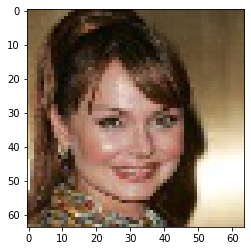

In [16]:
idx = 8
encode_to_attribs(c[idx])
plt.imshow(X[idx])

In [ ]:
def kl_divergence(y_true, y_pred):
    

In [ ]:
def vae_loss(y_true, y_pred):
    reconstruction_loss = mse(K.flatten(y_true), K.flatten(y_pred))
    reconstruction_loss *= width*height # common practice to scale with w*h
    kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
    kl_loss = K.sum(kl_loss, axis=-1)
    kl_loss *= -0.5
    kl_loss * beta
    return K.mean(reconstruction_loss + kl_loss)

In [34]:
epochs = 5
batch_size = 32

train_data = X[:10000]

noise = np.random.normal(0,1, 100)

num_batches = int(len(train_data) // batch_size)

loss_curve = []
for epoch in range(epochs):
    print(f'Epoch [{epoch}/{epochs-1}]...'.ljust(20), end = '')
    np.random.seed(epoch)
    np.random.shuffle(train_data)
    disc_loss_total = 0
    gen_loss_total = 0
    
    for index in range(num_batches):
        vae_loss += vae.train_on_batch(train_data[index*batch_size: batch_size*(index+1)],train_data[index*batch_size: batch_size*(index+1)])
    
    vae_loss /= num_batches
    print(f'loss:{vae_loss:.3f}')
    loss_curve.append(vae_loss)


Epoch [0/4]...      loss:118.275
Epoch [1/4]...      loss:116.597
Epoch [2/4]...      loss:116.031
Epoch [3/4]...      loss:115.343
Epoch [4/4]...      loss:114.804


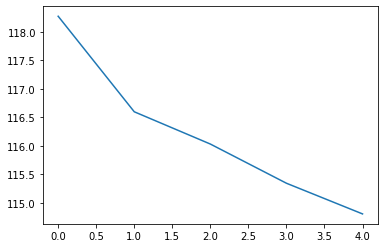

In [35]:
plt.plot(loss_curve)

In [50]:
val_imgs = X[10000:10010]

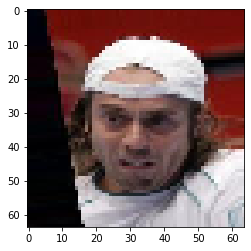

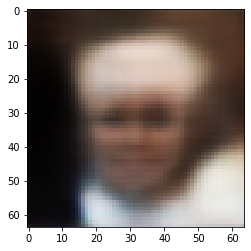

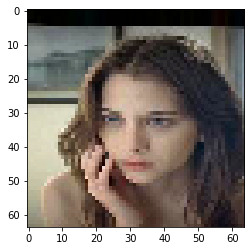

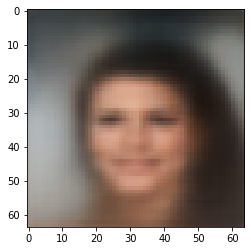

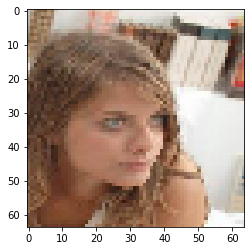

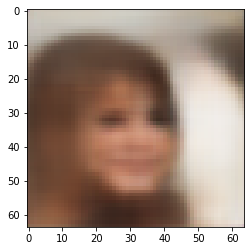

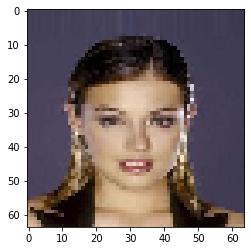

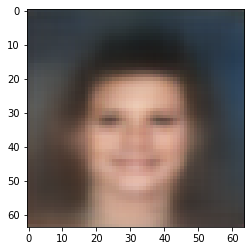

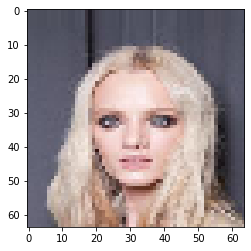

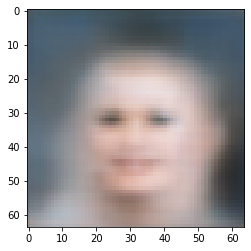

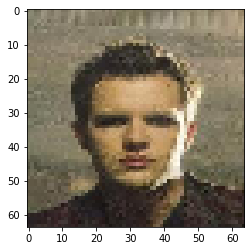

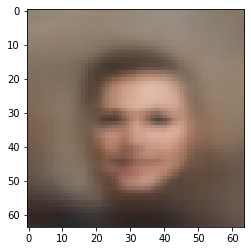

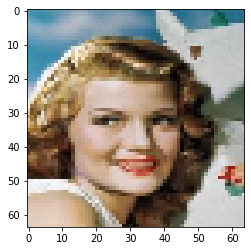

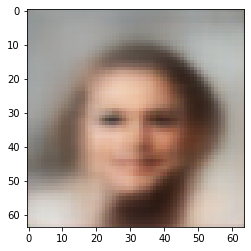

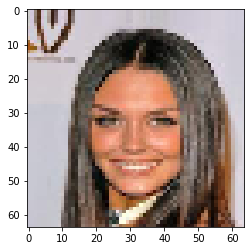

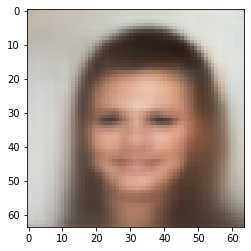

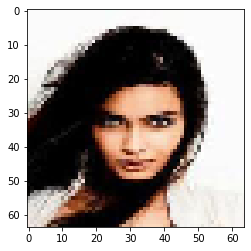

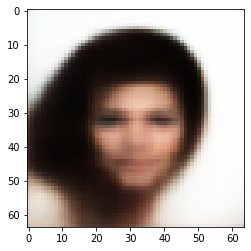

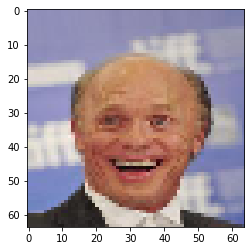

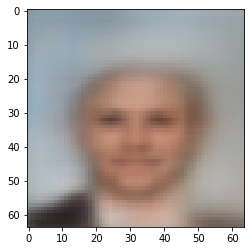

In [53]:
for image in val_imgs:
    plt.imshow(image)
    plt.show()
    plt.imshow(vae.predict(np.array([image]))[0])
    plt.show()

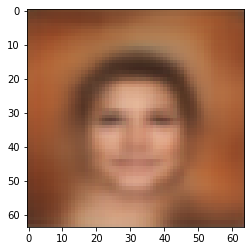

In [49]:
mu, sigma = 0, 1 #mean and standard deviation
s = np.random.normal(mu, sigma, latent_dim)
plt.imshow(decoder.predict(np.array([s]))[0])
plt.show()

In [99]:
vae.save('vanilla-VAE-150.h5', save_format='tf')

In [124]:
encoded = encoder.predict(np.array([imgs[idx]]))[0]

In [129]:
warmup_til_epoch=50
for epoch in range(100):
    value = (epoch/warmup_til_epoch) * (epoch <= warmup_til_epoch) + 1.0 * (epoch > warmup_til_epoch)
    print(value)

0.0
0.02
0.04
0.06
0.08
0.1
0.12
0.14
0.16
0.18
0.2
0.22
0.24
0.26
0.28
0.3
0.32
0.34
0.36
0.38
0.4
0.42
0.44
0.46
0.48
0.5
0.52
0.54
0.56
0.58
0.6
0.62
0.64
0.66
0.68
0.7
0.72
0.74
0.76
0.78
0.8
0.82
0.84
0.86
0.88
0.9
0.92
0.94
0.96
0.98
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0


In [126]:
s

array([-1.08106999,  0.32013323, -1.55818613, -0.45026854, -1.66310395,
        0.78569422, -1.39762405,  0.07338019,  1.1939133 ,  0.4395131 ,
        0.84212601,  0.72813559, -0.20395568, -0.55190861,  0.91331887,
       -0.52396943,  0.42840624,  1.52424608, -1.03515727, -0.56327838,
       -0.20883481,  0.21993302,  0.42961978, -0.23346862,  0.41999356,
       -1.33034769,  0.45838368,  0.56152947, -0.03538979, -1.64144032,
       -0.4171319 ,  1.4437737 , -0.3009611 ,  1.4147419 ,  0.37861709,
        0.51136094, -1.66606614, -0.78132097,  0.26521417, -2.84087669,
        0.14570408, -1.30468342,  1.07145666, -0.19641146, -0.79491905,
       -0.68028141,  0.07673936, -1.65081373,  0.41551591, -1.56793549,
       -0.53741953,  1.91968439, -0.45774273, -0.3253923 ,  0.26121327,
       -1.80431887, -1.50881659, -1.12793814,  0.41378639, -0.40247553,
        1.61163988,  0.21441996, -0.7190945 ,  0.32763873,  0.1133167 ,
       -0.7985691 ,  1.21927564, -0.06176024,  0.15438005, -0.24

In [6]:
vae = load_model('./vanilla-VAE-150.tf')

SystemError: unknown opcode

In [39]:
vae.load_weights('./DVAE-150.h5')

ValueError: You are trying to load a weight file containing 12 layers into a model with 20 layers.

In [29]:
vae.layers[2].load_weights('./DVAE-150.h5',by_name=True)

In [30]:
encoder = vae.layers[1]
decoder = vae.layers[2]

input_layer = Input(shape=(64,64,3))
vae.layers

In [17]:
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 64, 64, 16)   448         encoder_input[0][0]              
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 64, 64, 16)   64          conv2d[0][0]                     
__________________________________________________________________________________________________
leaky_re_lu (LeakyReLU)         (None, 64, 64, 16)   0           batch_normalization[0][0]        
____________________________________________________________________________________________

In [37]:
flatten_model(vae)

Note that input tensors are instantiated via `tensor = tf.keras.Input(shape)`.
The tensor that caused the issue was: encoder_input_4:0
Note that input tensors are instantiated via `tensor = tf.keras.Input(shape)`.
The tensor that caused the issue was: encoder_input_4:0
Note that input tensors are instantiated via `tensor = tf.keras.Input(shape)`.
The tensor that caused the issue was: encoder_input_4:0
Note that input tensors are instantiated via `tensor = tf.keras.Input(shape)`.
The tensor that caused the issue was: encoder_input_4:0
Note that input tensors are instantiated via `tensor = tf.keras.Input(shape)`.
The tensor that caused the issue was: encoder_input_4:0
Note that input tensors are instantiated via `tensor = tf.keras.Input(shape)`.
The tensor that caused the issue was: encoder_input_4:0
Note that input tensors are instantiated via `tensor = tf.keras.Input(shape)`.
The tensor that caused the issue was: encoder_input_4:0
Note that input tensors are instantiated via `tensor = 

ValueError: Input 0 of layer z_log_var is incompatible with the layer: expected axis -1 of input shape to have value 4096 but received input with shape [None, 200]

In [36]:
def flatten_model(model_nested):
    layers_flat = []
    for layer in model_nested.layers:
        try:
            layers_flat.extend(layer.layers)
        except AttributeError:
            layers_flat.append(layer)
    model_flat = tf.keras.models.Sequential(layers_flat)
    return model_flat

In [2]:
load_model('./vanilla-VAE-150.h5')

SystemError: unknown opcode